# Final

## In this milestone:
1. Models:
- K-Means with different parameters
- k-medoids
- AgglomerativeClustering (linkage = ["single", "complete, "average", "centroid, "ward"])
- DBSCAN with different eps, min_samples, metric
- GMM
2. PCA/TSNE

## Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

np.random.seed = 42

df=pd.read_csv('../data/for_modellers/after_scaling.csv')

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
seed=42

## 1. KMeans

### 1.1 eps

In [3]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

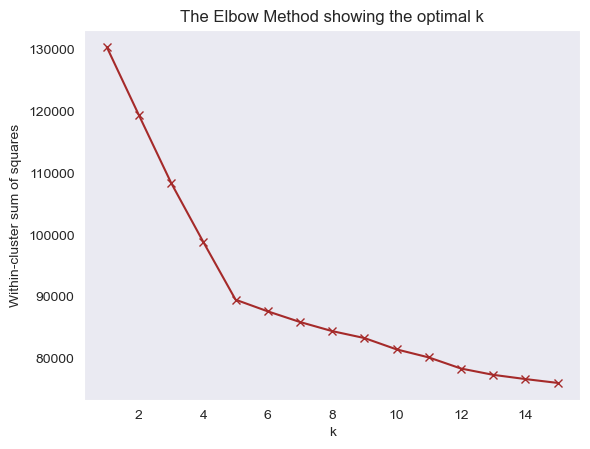

In [4]:
wcss_vec = count_wcss_scores(df, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.grid()
plt.show()

In [5]:
from sklearn.metrics import silhouette_score
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state = seed)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

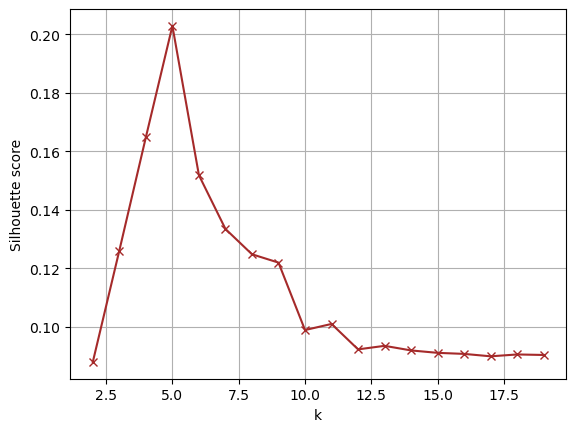

In [13]:
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [14]:
def metrics_plots(max_k=20):

    score = []

    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(df)
        score.append(kmeans.score(df))
        score_kmeans_c.append(calinski_harabasz_score(df, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(df, predictions))

    list_scores = [score, score_kmeans_c, score_kmeans_d] 
    list_title = ['Within-cluster sum of squares', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

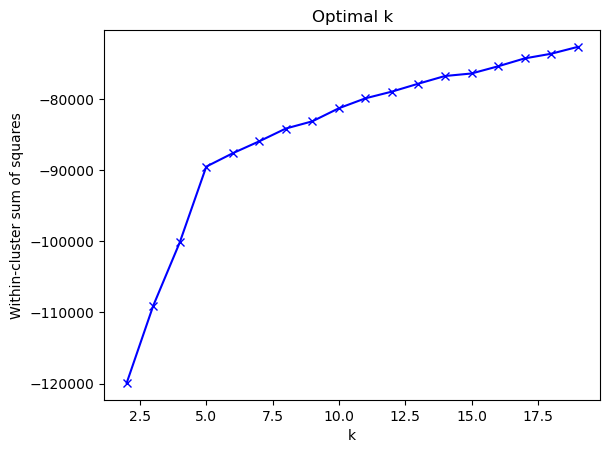

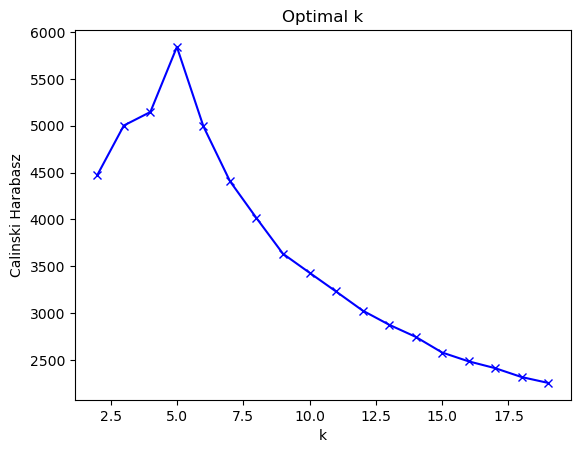

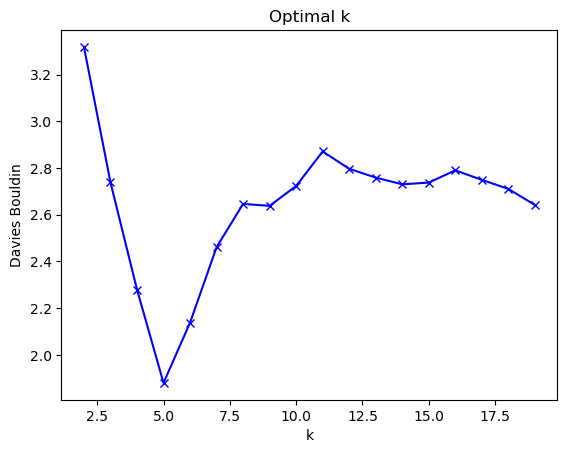

In [21]:
metrics_plots(20)

According to all metrics, we should have n_clusters=5.

### 1.2 different parameters

In [22]:
def evaluate_kmeans(X, init_methods, algorithms):
    results = []

    for alg in algorithms:
        for init in init_methods:
            kmeans = KMeans(n_clusters=5, init=init, algorithm = alg, random_state=42)
            labels = kmeans.fit_predict(X)

            inertia = kmeans.inertia_
            ch_score = calinski_harabasz_score(X, labels)
            db_score = davies_bouldin_score(X, labels)
            silhouette_avg = silhouette_score(X, labels)

            results.append({
                'algorithm': alg,
                'init': init,
                'inertia': inertia,
                'calinski_harabasz': ch_score,
                'davies_bouldin': db_score,
                'silhouette': silhouette_avg
            })

    return results

init_methods = ['k-means++', 'random']
algorithms = ['lloyd', 'elkan']

results = evaluate_kmeans(df, init_methods, algorithms)

import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)


  algorithm       init       inertia  calinski_harabasz  davies_bouldin  \
0     lloyd  k-means++  89502.694525        5840.430471        1.878062   
1     lloyd     random  89497.459630        5841.514091        1.903231   
2     elkan  k-means++  89502.694525        5840.430471        1.878062   
3     elkan     random  89497.459630        5841.514091        1.903231   

   silhouette  
0    0.202893  
1    0.202890  
2    0.202893  
3    0.202890  


algorithm doesn't change scores, kmeans++ is better in more metrics than random. Chosen parameters for K-Means: n_clusters=5, init="k_means++" 

## 2. K-medoids

In [4]:
import sklearn_extra

In [5]:
from sklearn_extra.cluster import KMedoids

In [6]:
def plot_kmedoids_clusters(X, n_clusters):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(X)
    y_kmedoids = kmedoids.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedoids, s=30, cmap='viridis')

    centers = kmedoids.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-medoids clusters')
    plt.show()

In [7]:
def metrics_plots_medoids(df, max_k=20):

    score_kmedoids_c = []
    score_kmedoids_d = []

    for k in range(2, max_k):
        kmedoids = KMedoids(n_clusters=k, random_state=101)
        predictions = kmedoids.fit_predict(df)
        score_kmedoids_c.append(calinski_harabasz_score(df, kmedoids.labels_))
        score_kmedoids_d.append(davies_bouldin_score(df, predictions))

    list_scores = [score_kmedoids_c, score_kmedoids_d] 
    list_title = ['Calinski Harabasz', 'Davies Bouldin'] 

    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

In [ ]:
metrics_plots_medoids(df=df)

The best parameters are:

## 1.3 AgglomerativeClustering

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.ticker import MaxNLocator

In [7]:
linkages = ['ward', 'complete', 'average', 'single']

In [ ]:
cluster_num_seq = range(2, 20)
davies_vec_kmeans = count_clustering_scores(df, cluster_num_seq, KMeans, davies_bouldin_score)
davies_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(df)
        wcss = davies_bouldin_score(df, labels)
        davies_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, davies_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, davies_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, davies_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, davies_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, davies_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output.jpg")
plt.show()

In [ ]:
# silhouette_score
cluster_num_seq = range(2, 20)
silhouette_vec_kmeans = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
silhouette_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(df)
        wcss = silhouette_score(df, labels)
        silhouette_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, silhouette_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output2.jpg")
plt.show()

## 1.4 DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
df.head()

In [ ]:
minPts = 162 #2*nr of columns
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od minPts-1 najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

In [ ]:
# List of parameters to test
eps_list = [1.0, 2.0, 3.0]
min_samples_list = [83, 100, 120, 140,162,180]
metric_list = ['euclidean', 'manhattan']

results = []
for eps in eps_list:
    for min_samples in min_samples_list:
        for metric in metric_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = dbscan.fit_predict(df)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'metric': metric,
                'labels': labels
            })


for result in results:
    print("Params:", result['eps'], result['min_samples'], result['metric'])
    print("Labels:", result['labels'])

## 1.5 GMM

In [ ]:
from sklearn.mixture import GaussianMixture


# List of parameters to test
n_components_list = range(2,20)
covariance_type_list = ['full', 'tied', 'diag', 'spherical']


results = []
for n_components in n_components_list:
    for covariance_type in covariance_type_list:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        labels = gmm.fit_predict(df)
        results.append({
            'n_components': n_components,
            'covariance_type': covariance_type,
            'labels': labels
        })


for result in results:
    print("Params:", result['n_components'], result['covariance_type'])
    print("Labels:", result['labels'])
